<h2>Classification of jewelry images </h2>

Due to the lack of large training data set and expensive training for deep networks, 
instead of training a convolution network from scratch, we use the pre-trained network weights as inputs. The features are extracted from an intermediate layer with VGG19 model. We then build various classifiers on those features. This is often called transfer learning.

### Get images (Cartier)

In [8]:
"""
Scrape the data from the Cartier web pages.
Including product category, collections, price, stone shape and image address.
"""
import urllib.request
import pandas as pd
import numpy as np
data = pd.read_csv('/data/notebooks/visualrecommender/cartier_images_500.csv')
print(data.shape)
data[0:3]

(477, 7)


,Unnamed: 0,Category,Collections,Image,Metal,Price,Stone shape
0,0,Bracelets,Juste un clou,http://www.cartier.com/content/dam/rcq/car/58/...,Pink Gold,6800,NaN
1,1,Bracelets,Juste un clou,http://www.cartier.com/content/dam/rcq/car/59/...,Yellow Gold,6800,NaN
2,2,Bracelets,Juste un clou,http://www.cartier.com/content/dam/rcq/car/13/...,White Gold,7300,NaN


In [9]:
data.groupby("Category").agg("count")

,Unnamed: 0,Collections,Image,Metal,Price,Stone shape
Category,,,,,,
Bracelets,140,140,140,139,140,65
Earrings,73,73,73,73,73,34
Necklaces,139,139,139,138,139,77
Rings,120,120,120,120,120,3


In [10]:
data.groupby(["Category","Metal"]).agg("count")

Unnamed: 0  Collections  Image  Price  Stone shape
Category  Metal                                                          
Bracelets Pink Gold            46           46     46     46           27
          Platinum              5            5      5      5            0
          White Gold           41           41     41     41           20
          Yellow Gold          38           38     38     38           16
          three-gold            9            9      9      9            2
Earrings  Pink Gold            22           22     22     22           13
          Platinum              8            8      8      8            1
          White Gold           19           19     19     19            7
          Yellow Gold          15           15     15     15            7
          three-gold            9            9      9      9            6
Necklaces Pink Gold            42           42     42     42           28
          Platinum             10           10     10     10            0
          White Gold           39           39     39     39           20
          Yellow Gold          30           30     30     30           18
          three-gold           17           17     17     17           10
Rings     Pink Gold            42           42     42     42            2
          Platinum              6            6      6      6            0
          White Gold           37           37     37     37            1
          Yellow Gold          24           24     24     24            0
          three-gold           11           11     11     11            0

In [11]:
"""
Calculate the number of products in each category 
"""
Category_images = {} 
for i in range(477):
    item = data.loc[i]
    category  = item[1]
    image = item[3]
    if category in Category_images:
        Category_images[category].append(image)
    else:
        Category_images[category] = [image]
print("The list of categories: \n",Category_images.keys())
for key in Category_images.keys():
    print(len(Category_images[key]))
    
#the catier images contain 4 different categories including bracelets, rings, earrings, necklaces.
category = ['Bracelets', 'Rings', 'Earrings', 'Necklaces']

The list of categories: 
 dict_keys([nan, 'Rings', 'Earrings', 'Bracelets', 'Necklaces'])
5
120
73
140
139


# <font color="red">I. Feature extraction
<h3>In this part, we extract the features from an intermediate layer in the VGG19 model</h3>

### 1. Loading and pre-processing an image

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


PIL image size (224, 224)


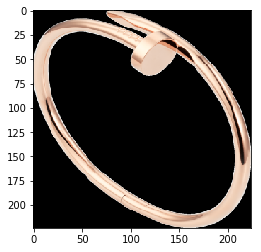

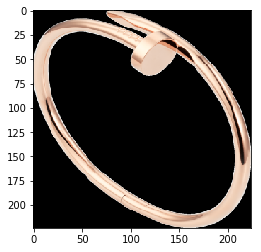

numpy array size (224, 224, 3)
image batch size (1, 224, 224, 3)


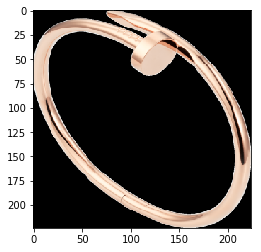

In [12]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import decode_predictions
import matplotlib.pyplot as plt
%matplotlib inline

directory1 = '/data/notebooks/visualrecommender/Images/Images_Cartier/'
directory3 = '.jpg'
        
key = 'Bracelets'
directory2 = key+str('/')
index = 0
img_path = directory1+directory2+str(index)+directory3

filename = img_path
# load an image in PIL format
original = load_img(filename, target_size=(224, 224))
print('PIL image size',original.size)
plt.imshow(original)
plt.show()
 
# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
numpy_image = img_to_array(original)
plt.imshow(np.uint8(numpy_image))
plt.show()
print('numpy array size',numpy_image.shape)
 
# Convert the image / images into batch format
# expand_dims will add an extra dimension to the data at a particular axis
# We want the input matrix to the network to be of the form (batchsize, height, width, channels)
# Thus we add the extra dimension to the axis 0.
image_batch = np.expand_dims(numpy_image, axis=0)
print('image batch size', image_batch.shape)
plt.imshow(np.uint8(image_batch[0]))

In [13]:
#the input data for Keras requires 4 dimensional tensor 
def img_preprocess(img_path):
    """
    Function to process the raw image.
    Given an image path, return a processed image x,
    which can be used to train the VGG model.
    Output a 4-D tensor (1,224,224,3)
    width is 224, height is 224, 3 channels 
    """
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x   

In [14]:
from keras.applications.vgg19 import VGG19
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
import numpy as np

### 2. Load the VGG19 model

In [15]:
"""
Arguments of VGG19 model:
1. include_top: whether to include the 3 fully-connected
            layers on top of the network.
2. weights: 'imagenet' (pre-training on ImageNet)
"""

model = VGG19(weights='imagenet') #the default argument: include_top = True.
print("The summary of the VGG19 network layers:")
model.summary()

The summary of the VGG19 network layers:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None,

In [16]:
"""
Obtain the predictions using VGG19 model
Using the weights from the pretrained imagenet.
The imagenet data set contains 1000 classes.
"""
model = VGG19(weights='imagenet')

key = 'Bracelets'
directory2 = key+str('/')
index = 0
img_path = directory1+directory2+str(index)+directory3

print("The shape of the input image: ",img_preprocess(img_path).shape)
preds = model.predict(img_preprocess(img_path))
print('Top 3 predicted classes: \n', decode_predictions(preds, top=3)[0])

The shape of the input image:  (1, 224, 224, 3)
Top 3 predicted classes: 
 [('n01930112', 'nematode', 0.26199836), ('n03627232', 'knot', 0.23536704), ('n03532672', 'hook', 0.11476586)]


In [8]:
#base_model: use the weigths from the pre-trained imagenet data set. 
#the model is VGG19.
base_model = VGG19(weights='imagenet') #download weights from pre-trained imagenet data set

def Get_layer(layer):
    """
    Return a model with the specified layer
    layer: flatten, fc1, fc2 ...
    """
    model = Model(inputs=base_model.input, outputs=base_model.get_layer(layer).output)
    return model

def Get_feature(img_path,model):
    """
    Return the features of an intermediate layer from the defined model.
    In this case, model = Get_layer(...)
    """
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    #print(features.shape)
    return features   

In [9]:
#extract features from different intermediate layers: block5_pool, flatten, fc1
#the input data is one bracelet image. 
key = 'Bracelets'
directory2 = key+str('/')
index = 0
img_path = directory1+directory2+str(index)+directory3

layers = ['block1_conv1','block5_pool','flatten','fc1']
for layer in layers:
    model_feature = Get_layer(layer)
    feature = Get_feature(img_path,model_feature)
    print("The size of the features from the %s layer is %s"%(layer,feature.shape)) 
    

The size of the features from the block1_conv1 layer is (1, 224, 224, 64)
The size of the features from the block5_pool layer is (1, 7, 7, 512)
The size of the features from the flatten layer is (1, 25088)
The size of the features from the fc1 layer is (1, 4096)


### 3. Extract the features from the first fully connected layer 

In [10]:
#specify the first fully connected layer as the output layer 
model1 = Get_layer('fc1')

#get the freatures of the input images and save the data in a dataframe.
def Get_featues_df(key):
    """
    key: the specified category (bracelets, earrings, necklaces, rings)
    return a dataframe which contains all the features with the given key
    """
    directory2 = key+str('/')
    print(len(Category_images[key]))
    
    data_df_i = pd.DataFrame()
    for index in range(len(Category_images[key])):
        img_path = directory1+directory2+str(index)+directory3
        fc1_feature = Get_feature(img_path,model1)
        data_df_i = data_df_i.append(pd.DataFrame(fc1_feature),ignore_index=True)
    return data_df_i   

In [11]:
#data_df_1 contains features of Bracelets
key = 'Bracelets'
data_df_1 = Get_featues_df(key)

140


In [12]:
#data_df_2 contains features of earrings 
key = 'Earrings'
data_df_2 = Get_featues_df(key)

73


In [13]:
#data_df_3 contains featurs of necklaces 
key = 'Necklaces'
data_df_3 = Get_featues_df(key)

139


In [14]:
#data_df_4 contains features of rings 
key = 'Rings'
data_df_4 = Get_featues_df(key)

120


# <font color="red">Logistic Regression Model</font>
### Build model on the Cartier data set 

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
import statsmodels.api as sm
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python3.5/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### 1. Classify Necklaces (binary, one-vs-rest)
Set necklaces as the positive class and the rest as the negative class.

In [16]:
data_all = data_df_3.append(data_df_1,ignore_index=True).append(data_df_2,ignore_index=True).append(data_df_4,ignore_index=True)

labels = [1]*len(Category_images['Necklaces'])+[0]*(len(Category_images['Rings'])+len(Category_images['Earrings'])+len(Category_images['Bracelets']))

df_labels = pd.DataFrame({'Labels':labels})
print(df_labels['Labels'].value_counts())

0    333
1    139
Name: Labels, dtype: int64


In [17]:
Y = np.ravel(df_labels.Labels)# we need 1D array for the target
X = data_all

#train and test split: 3/5 as the training set and the rest as the testing set
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,
                                              random_state=3)
print(X_train.shape,X_test.shape)

log_model2 = LogisticRegression()
log_model2.fit(X_train,Y_train)

class_predict=log_model2.predict(X_test)
print(metrics.accuracy_score(Y_test,class_predict))
print(classification_report(Y_test,class_predict))
print("Confusion matrix: \n",confusion_matrix(Y_test, class_predict))

(354, 4096) (118, 4096)
0.9830508474576272
             precision    recall  f1-score   support

          0       0.97      1.00      0.99        78
          1       1.00      0.95      0.97        40

avg / total       0.98      0.98      0.98       118

Confusion matrix: 
 [[78  0]
 [ 2 38]]


### 2. Classify Rings (binary)
Set rings as the positive class and the rest as the negative class.

In [18]:
data_all = data_df_4.append(data_df_1,ignore_index=True).append(data_df_2,ignore_index=True).append(data_df_3,ignore_index=True)

labels = [1]*len(Category_images['Rings'])+[0]*(len(Category_images['Necklaces'])+len(Category_images['Earrings'])+len(Category_images['Bracelets']))

df_labels = pd.DataFrame({'Labels':labels})
print(df_labels['Labels'].value_counts())

0    352
1    120
Name: Labels, dtype: int64


In [19]:
Y = np.ravel(df_labels.Labels)# we need 1D array for the target
X = data_all
#train and test split: 3/5 as the training set and the rest as the testing set
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,
                                              random_state=3)
print(X_train.shape,X_test.shape)

log_model2 = LogisticRegression()
log_model2.fit(X_train,Y_train)

class_predict=log_model2.predict(X_test)
print(metrics.accuracy_score(Y_test,class_predict))
print(classification_report(Y_test,class_predict))
print("Confusion matrix: \n",confusion_matrix(Y_test, class_predict))

(354, 4096) (118, 4096)
0.9661016949152542
             precision    recall  f1-score   support

          0       0.99      0.97      0.98        87
          1       0.91      0.97      0.94        31

avg / total       0.97      0.97      0.97       118

Confusion matrix: 
 [[84  3]
 [ 1 30]]


### 3. Classify Earrings (binary)
Set earrings as the positive class and the rest as the negative class.

In [20]:
data_all = data_df_2.append(data_df_1,ignore_index=True).append(data_df_4,ignore_index=True).append(data_df_3,ignore_index=True)

labels = [1]*len(Category_images['Earrings'])+[0]*(len(Category_images['Necklaces'])+len(Category_images['Rings'])+len(Category_images['Bracelets']))

df_labels = pd.DataFrame({'Labels':labels})
print(df_labels['Labels'].value_counts())

0    399
1     73
Name: Labels, dtype: int64


In [21]:
Y = np.ravel(df_labels.Labels)# we need 1D array for the target
X = data_all

#train and test split: 3/5 as the training set and the rest as the testing set
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,
                                              random_state=3)
print(X_train.shape,X_test.shape)

log_model2 = LogisticRegression()
log_model2.fit(X_train,Y_train)

class_predict=log_model2.predict(X_test)
print(metrics.accuracy_score(Y_test,class_predict))
print(classification_report(Y_test,class_predict))
print("Confusion matrix: \n",confusion_matrix(Y_test, class_predict))

(354, 4096) (118, 4096)
0.9830508474576272
             precision    recall  f1-score   support

          0       0.99      0.99      0.99       101
          1       0.94      0.94      0.94        17

avg / total       0.98      0.98      0.98       118

Confusion matrix: 
 [[100   1]
 [  1  16]]


### 4. Classify Bracelets (binary)
Set bracelets as the positive class and the rest as the negative class.

In [22]:
data_all = data_df_1.append(data_df_2,ignore_index=True).append(data_df_3,ignore_index=True).append(data_df_4,ignore_index=True)

labels = [1]*len(Category_images['Bracelets'])+[0]*(len(Category_images['Necklaces'])+len(Category_images['Rings'])+len(Category_images['Earrings']))

df_labels = pd.DataFrame({'Labels':labels})
print(df_labels['Labels'].value_counts())

0    332
1    140
Name: Labels, dtype: int64


In [23]:
Y = np.ravel(df_labels.Labels)# we need 1D array for the target
X = data_all

#train and test split: 3/5 as the training set and the rest as the testing set
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,
                                              random_state=3)
print(X_train.shape,X_test.shape)

log_model2 = LogisticRegression() #default is l2 regularization
log_model2.fit(X_train,Y_train)

class_predict=log_model2.predict(X_test)

print(metrics.accuracy_score(Y_test,class_predict))
print(classification_report(Y_test,class_predict))
print("Confusion matrix: \n",confusion_matrix(Y_test, class_predict))

(354, 4096) (118, 4096)
0.9491525423728814
             precision    recall  f1-score   support

          0       0.93      1.00      0.96        77
          1       1.00      0.85      0.92        41

avg / total       0.95      0.95      0.95       118

Confusion matrix: 
 [[77  0]
 [ 6 35]]


### <font color="red">5. Multinomial logistic regression classifier (4 classes: bracelets, earrings, necklaces, rings)<font>
Set bracelets as class 1, earrings as class 2, necklaces as class 3 and rings as class 4.

In [25]:
data_all = data_df_1.append(data_df_2,ignore_index=True).append(data_df_3,ignore_index=True).append(data_df_4,ignore_index=True)

labels = [1]*len(Category_images['Bracelets'])+[2]*len(Category_images['Earrings'])+[3]*len(Category_images['Necklaces'])+[4]*len(Category_images['Rings'])

df_labels = pd.DataFrame({'Labels':labels})
print(df_labels['Labels'].value_counts())

1    140
3    139
4    120
2     73
Name: Labels, dtype: int64


In [26]:
Y = np.ravel(df_labels.Labels)# we need 1D array for the target
X = data_all

#train and test split: 3/5 as the training set and the rest as the testing set
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.25,
                                              random_state=3)
print(X_train.shape,X_test.shape)

log_model2 = LogisticRegression(multi_class='multinomial',solver='newton-cg')
log_model2.fit(X_train,Y_train)

class_predict=log_model2.predict(X_test)

print("l2 regularization =====> ")
print(metrics.accuracy_score(Y_test,class_predict))
print(classification_report(Y_test,class_predict))
print("Confusion matrix: \n",confusion_matrix(Y_test, class_predict))

(354, 4096) (118, 4096)
l2 regularization =====> 
0.9830508474576272
             precision    recall  f1-score   support

          1       1.00      0.98      0.99        41
          2       0.95      0.95      0.95        21
          3       0.97      1.00      0.98        28
          4       1.00      1.00      1.00        28

avg / total       0.98      0.98      0.98       118

Confusion matrix: 
 [[40  1  0  0]
 [ 0 20  1  0]
 [ 0  0 28  0]
 [ 0  0  0 28]]


### <font color="red">Support Vector Machine classifier (4 classes: bracelets, earrings, necklaces, rings)<font>
Set bracelets as class 1, earrings as class 2, necklaces as class 3 and rings as class 4. I tried two different regularization penalties (l1 and l2) to avoid overfitting problem. 

In [27]:
import random
from sklearn import cross_validation, svm, datasets, grid_search
from sklearn import metrics
import time, sys
import scipy.io
from scipy.stats import mode
from sklearn.neighbors import KDTree
from sklearn.externals.joblib import Memory
from sklearn.svm import LinearSVC

/usr/local/lib/python3.5/dist-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [28]:
#default is the l2 penalty. 
linearsvc = LinearSVC(random_state=0) 
linearsvc.fit(X_train, Y_train)
predict_linearsvc = linearsvc.predict(X_test)

print("l2 regularization penalty ======> \n")
print("Accuracy: ",metrics.accuracy_score(Y_test,predict_linearsvc))
print(classification_report(Y_test,predict_linearsvc))
print("Confusion matrix: \n",confusion_matrix(Y_test, predict_linearsvc))

#use l1 regularization penalty. 
linearsvc_1 = LinearSVC(penalty='l1', loss='squared_hinge', dual=False,
                       tol=1e-3)
linearsvc_1.fit(X_train, Y_train)
predict_linearsvc_1 = linearsvc_1.predict(X_test)

print("\n l1 regularization penalty ======> \n")
print("Accuracy: ",metrics.accuracy_score(Y_test,predict_linearsvc_1))
print(classification_report(Y_test,predict_linearsvc_1))
print("Confusion matrix: \n",confusion_matrix(Y_test, predict_linearsvc_1))

l2 regularization penalty ======> 

Accuracy:  0.9830508474576272
             precision    recall  f1-score   support

          1       1.00      0.98      0.99        41
          2       0.95      0.95      0.95        21
          3       0.97      1.00      0.98        28
          4       1.00      1.00      1.00        28

avg / total       0.98      0.98      0.98       118

Confusion matrix: 
 [[40  1  0  0]
 [ 0 20  1  0]
 [ 0  0 28  0]
 [ 0  0  0 28]]

 l1 regularization penalty ======> 

Accuracy:  0.9661016949152542
             precision    recall  f1-score   support

          1       1.00      0.95      0.97        41
          2       0.95      0.90      0.93        21
          3       0.97      1.00      0.98        28
          4       0.93      1.00      0.97        28

avg / total       0.97      0.97      0.97       118

Confusion matrix: 
 [[39  1  0  1]
 [ 0 19  1  1]
 [ 0  0 28  0]
 [ 0  0  0 28]]
